<a href="https://colab.research.google.com/github/LinaMariaCastro/curso-ia-para-economia/blob/main/clases/5_Aprendizaje_supervisado/3_Regresion_Logistica_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inteligencia Artificial con Aplicaciones en Economía I**

- 👩‍🏫 **Profesora:** [Lina María Castro](https://www.linkedin.com/in/lina-maria-castro)  
- 📧 **Email:** [lmcastroco@gmail.com](mailto:lmcastroco@gmail.com)  
- 🎓 **Universidad:** Universidad Externado de Colombia - Facultad de Economía

# 🚦 **Regresión Logística para problemas de clasificación**

**Objetivos de Aprendizaje:**

Al finalizar este notebook, serás capaz de:

1.  **Entender la intuición** detrás de la Regresión Logística y cómo se aplica a problemas de clasificación (ej. aprobar/rechazar un crédito).
2.  **Implementar un modelo de clasificación** en Python para predecir el riesgo crediticio de un cliente.
3.  **Evaluar un modelo de clasificación** más allá de la simple exactitud (Accuracy), comprendiendo la importancia de la Matriz de Confusión, la Precisión, la Sensibilidad, la Especificidad, el F1-Score y la Curva ROC en un contexto de negocio.

**Introducción**

Hasta ahora, hemos usado la regresión lineal para predecir *números* (ej. el precio de una casa). Pero en economía y negocios, muchas de las decisiones importantes no son sobre números, sino sobre *categorías*: ¿Comprará el cliente este producto? (Sí/No), ¿Entrará la economía en recesión el próximo trimestre? (Sí/No), o el caso que nos ocupa hoy: **¿Debería el banco aprobarle un crédito a este solicitante? (Sí/No)**.

Analogía: Del Termómetro a la Bombilla 🌡️ ➡️ 💡

Piensa en la **regresión lineal** como un **termómetro**. Nos da una medida continua y precisa de la temperatura (ej. un precio de $150.250,75). Sin embargo, para una decisión de 'aprobar/no aprobar', necesitamos algo más simple: una **bombilla** que esté encendida (Aprobar) o apagada (Rechazar).

La **Regresión Logística** es el mecanismo que nos permite conectar el termómetro a la bombilla. No predice directamente un 0 o un 1, sino la **probabilidad** de que la bombilla se encienda. Por ejemplo, podría decirnos: "Basado en los datos de este cliente (ingresos, deudas, historial), hay un 85% de probabilidad de que pague el crédito". Luego, el banco define una regla de decisión: "Si la probabilidad es mayor al 70%, encendemos la bombilla (aprobamos el crédito), de lo contrario, la apagamos (no aprobamos el crédito)".

## Importar Librerías

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

## Mejorar visualización de dataframes y gráficos

In [2]:
# Que muestre todas las columnas
pd.options.display.max_columns = None
# En los dataframes, mostrar los float con dos decimales
pd.options.display.float_format = '{:,.2f}'.format

# Configuraciones para una mejor visualización
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Cargar datos

Usaremos el dataset **German Credit Data** (https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data), el cual contiene información sobre 1000 solicitantes de crédito. El conjunto de datos incluye a individuos a quienes efectivamente se les otorgó un crédito. No contiene información sobre los solicitantes que fueron rechazados.

Para cada uno de estos 1000 individuos, el banco ya realizó una clasificación de riesgo a posteriori, es decir, después de observar su comportamiento de pago. **La columna objetivo es Risk (o 'Riesgo')** indica si, con el tiempo, el cliente resultó ser un buen pagador (cumplió con sus obligaciones) o un mal pagador (incurrió en impago o default).

Por lo tanto, el objetivo de un modelo entrenado con estos datos no es decidir si se aprueba o no un crédito (ya que todos fueron aprobados), sino predecir, en el momento de la solicitud, la probabilidad de que un cliente aprobado se convierta en un mal pagador en el futuro.

In [3]:
# Cargar el dataset desde una URL pública
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
# Los nombres de las columnas se encuentran en la documentación del dataset
columns = ['Estado de la cuenta corriente existente', 'Duración en meses', 'Historia de crédito', 'Propósito',
           'Monto del crédito',
           'Cuenta de ahorros/bonos', 'Empleo actual desde',
           'Tasa de pago a plazos en porcentaje del ingreso disponible',
           'Estado personal y sexo', 'Otros deudores/fiadores', 'Residencia actual desde', 'Propiedad',
           'Edad', 'Otros planes de pago', 'Alojamiento', 'Número de créditos existentes en este banco',
           'Trabajo', 'Número de personas obligadas a prestar manutención a', 'Teléfono', 'Trabajador extranjero',
           'Riesgo']

df = pd.read_csv(url, sep=' ', header=None, names=columns)

# Vistazo inicial a los datos
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (1000, 21)


,Estado de la cuenta corriente existente,Duración en meses,Historia de crédito,Propósito,Monto del crédito,Cuenta de ahorros/bonos,Empleo actual desde,Tasa de pago a plazos en porcentaje del ingreso disponible,Estado personal y sexo,Otros deudores/fiadores,Residencia actual desde,Propiedad,Edad,Otros planes de pago,Alojamiento,Número de créditos existentes en este banco,Trabajo,Número de personas obligadas a prestar manutención a,Teléfono,Trabajador extranjero,Riesgo
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
# --- 1. Definición de los Diccionarios de Mapeo ---

# Atributo 1: Estado de la cuenta corriente existente
estado_cuenta_corriente_map = {
    'A11': 'Menos de 0 DM',
    'A12': 'Entre 0 y 200 DM',
    'A13': 'Más de 200 DM / Salario asignado',
    'A14': 'Sin cuenta corriente'
}

# Atributo 3: Historial crediticio
historial_crediticio_map = {
    'A30': 'Sin créditos / Todos pagados',
    'A31': 'Todos los créditos en este banco pagados',
    'A32': 'Créditos existentes pagados hasta ahora',
    'A33': 'Retraso en pagos en el pasado',
    'A34': 'Cuenta crítica / Otros créditos'
}

# Atributo 4: Propósito del crédito
proposito_map = {
    'A40': 'Automóvil (nuevo)',
    'A41': 'Automóvil (usado)',
    'A42': 'Muebles / Equipo',
    'A43': 'Radio / Televisión',
    'A44': 'Electrodomésticos',
    'A45': 'Reparaciones',
    'A46': 'Educación',
    'A48': 'Reciclaje',
    'A49': 'Negocios',
    'A410': 'Otros'
}

# Atributo 6: Cuenta de ahorros/bonos
cuenta_ahorros_map = {
    'A61': 'Menos de 100 DM',
    'A62': 'Entre 100 y 500 DM',
    'A63': 'Entre 500 y 1000 DM',
    'A64': 'Más de 1000 DM',
    'A65': 'Desconocido / Sin cuenta'
}

# Atributo 7: Empleo actual desde
empleo_actual_map = {
    'A71': 'Desempleado',
    'A72': 'Menos de 1 año',
    'A73': 'Entre 1 y 4 años',
    'A74': 'Entre 4 y 7 años',
    'A75': 'Más de 7 años'
}

# Atributo 9: Estado civil y sexo
estado_civil_sexo_map = {
    'A91': 'Hombre: divorciado/separado',
    'A92': 'Mujer: divorciada/separada/casada',
    'A93': 'Hombre: soltero',
    'A94': 'Hombre: casado/viudo',
    'A95': 'Mujer: soltera'
}

# Atributo 10: Otros deudores/fiadores
otros_deudores_map = {
    'A101': 'Ninguno',
    'A102': 'Co-solicitante',
    'A103': 'Garante'
}

# Atributo 12: Propiedad
propiedad_map = {
    'A121': 'Bienes inmuebles',
    'A122': 'Seguro de vida / Ahorro para vivienda',
    'A123': 'Automóvil u otro',
    'A124': 'Desconocido / Sin propiedad'
}

# Atributo 14: Otros planes de pago
otros_planes_pago_map = {
    'A141': 'Banco',
    'A142': 'Tiendas',
    'A143': 'Ninguno'
}

# Atributo 15: Alojamiento
vivienda_map = {
    'A151': 'Alquiler',
    'A152': 'Propia',
    'A153': 'Gratuita'
}

# Atributo 17: Trabajo
empleo_map = {
    'A171': 'Desempleado / No cualificado - no residente',
    'A172': 'No cualificado - residente',
    'A173': 'Empleado cualificado / Funcionario',
    'A174': 'Directivo / Autónomo / Altamente cualificado'
}

# Atributo 19: Teléfono
telefono_map = {
    'A191': 'No tiene',
    'A192': 'Sí, a su nombre'
}

# Atributo 20: trabajador extranjero
trabajador_extranjero_map = {
    'A201': 'Sí',
    'A202': 'No'
}

# --- 2. Aplicación de los Mapeos al DataFrame ---
# Se aplica el mapeo a cada columna usando los nombres en español
df['Estado de la cuenta corriente existente'] = df['Estado de la cuenta corriente existente'].map(estado_cuenta_corriente_map)
df['Historia de crédito'] = df['Historia de crédito'].map(historial_crediticio_map)
df['Propósito'] = df['Propósito'].map(proposito_map)
df['Cuenta de ahorros/bonos'] = df['Cuenta de ahorros/bonos'].map(cuenta_ahorros_map)
df['Empleo actual desde'] = df['Empleo actual desde'].map(empleo_actual_map)
df['Estado personal y sexo'] = df['Estado personal y sexo'].map(estado_civil_sexo_map)
df['Otros deudores/fiadores'] = df['Otros deudores/fiadores'].map(otros_deudores_map)
df['Propiedad'] = df['Propiedad'].map(propiedad_map)
df['Otros planes de pago'] = df['Otros planes de pago'].map(otros_planes_pago_map)
df['Alojamiento'] = df['Alojamiento'].map(vivienda_map)
df['Trabajo'] = df['Trabajo'].map(empleo_map)
df['Teléfono'] = df['Teléfono'].map(telefono_map)
df['Trabajador extranjero'] = df['Trabajador extranjero'].map(trabajador_extranjero_map)

# --- 3. Verificación de los Resultados ---
print("DataFrame con valores reemplazados y columnas en español:")
display(df.head(3))

DataFrame con valores reemplazados y columnas en español:


,Estado de la cuenta corriente existente,Duración en meses,Historia de crédito,Propósito,Monto del crédito,Cuenta de ahorros/bonos,Empleo actual desde,Tasa de pago a plazos en porcentaje del ingreso disponible,Estado personal y sexo,Otros deudores/fiadores,Residencia actual desde,Propiedad,Edad,Otros planes de pago,Alojamiento,Número de créditos existentes en este banco,Trabajo,Número de personas obligadas a prestar manutención a,Teléfono,Trabajador extranjero,Riesgo
0,Menos de 0 DM,6,Cuenta crítica / Otros créditos,Radio / Televisión,1169,Desconocido / Sin cuenta,Más de 7 años,4,Hombre: soltero,Ninguno,4,Bienes inmuebles,67,Ninguno,Propia,2,Empleado cualificado / Funcionario,1,"Sí, a su nombre",Sí,1
1,Entre 0 y 200 DM,48,Créditos existentes pagados hasta ahora,Radio / Televisión,5951,Menos de 100 DM,Entre 1 y 4 años,2,Mujer: divorciada/separada/casada,Ninguno,2,Bienes inmuebles,22,Ninguno,Propia,1,Empleado cualificado / Funcionario,1,No tiene,Sí,2
2,Sin cuenta corriente,12,Cuenta crítica / Otros créditos,Educación,2096,Menos de 100 DM,Entre 4 y 7 años,2,Hombre: soltero,Ninguno,3,Bienes inmuebles,49,Ninguno,Propia,1,No cualificado - residente,2,No tiene,Sí,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                      Non-Null Count  Dtype 
---  ------                                                      --------------  ----- 
 0   Estado de la cuenta corriente existente                     1000 non-null   object
 1   Duración en meses                                           1000 non-null   int64 
 2   Historia de crédito                                         1000 non-null   object
 3   Propósito                                                   1000 non-null   object
 4   Monto del crédito                                           1000 non-null   int64 
 5   Cuenta de ahorros/bonos                                     1000 non-null   object
 6   Empleo actual desde                                         1000 non-null   object
 7   Tasa de pago a plazos en porcentaje del ingreso disponible  1000 non-null   int64 
 8   Estado pe

## Limpieza de la Variable Objetivo

`Riesgo` es nuestra variable objetivo. Está codificada como 1 para 'Bueno' y 2 para 'Malo'. Vamos a recodificarla a 1 para 'Bueno' y 0 para 'Malo'.

- **1 = Buen pagador**
- **0 = Mal pagador**

In [6]:
# Usamos .map() para la recodificación
df['Riesgo'] = df['Riesgo'].map({1: 1, 2: 0})

print("Distribución de la variable objetivo 'Riesgo':")
print(df['Riesgo'].value_counts(normalize=True))

Distribución de la variable objetivo 'Riesgo':
Riesgo
1   0.70
0   0.30
Name: proportion, dtype: float64


Vemos un desbalance: 70% de los clientes son buenos pagadores y 30% son malos pagadores.

**NOTA:** El problema del desbalance de clases se considera leve a partir de una proporción 55/45, se vuelve relevante a partir de una proporción 70/30 y se considera significativo a partir de 80/20.

## Análisis Exploratorio de Datos (EDA)

Antes de construir el modelo, exploremos un poco los datos. ¿Cómo se distribuye el riesgo crediticio en nuestra muestra?

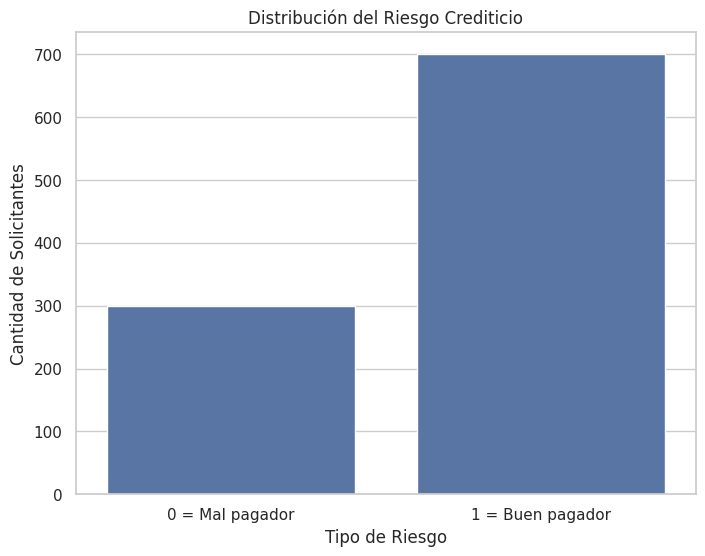

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Riesgo', data=df)
plt.title('Distribución del Riesgo Crediticio')
plt.xlabel('Tipo de Riesgo')
plt.ylabel('Cantidad de Solicitantes')
plt.xticks([0, 1], ['0 = Mal pagador', '1 = Buen pagador'])
plt.show()

**Interpretación Económica:** Vemos que tenemos **700 clientes clasificados como 'Buen pagador'** y **300 como 'Mal pagador'**. Esto se conoce como un **dataset desbalanceado**.

¡Es una característica muy común en problemas económicos! Hay menos casos de fraude que de no fraude, menos recesiones que expansiones, etc. Este desbalance es clave y afectará cómo evaluamos nuestro modelo más adelante.

## Preprocesamiento para el Modelo

Nuestro modelo de regresión logística necesita que todas las variables de entrada sean numéricas. El dataset contiene varias columnas categóricas (como `purpose` o `housing`). Usaremos la técnica **One-Hot Encoding** (con `pd.get_dummies`) para convertirlas en variables numéricas que el modelo pueda entender.

Además, dividiremos los datos en entrenamiento y prueba, y estandarizaremos las variables numéricas.

In [8]:
# 1. Identificamos variables categóricas y numéricas
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=np.number).columns.drop('Riesgo')
print(f"Categoricas: {categorical_cols}")
print(f"Numéricas: {numerical_cols}")

Categoricas: Index(['Estado de la cuenta corriente existente', 'Historia de crédito',
       'Propósito', 'Cuenta de ahorros/bonos', 'Empleo actual desde',
       'Estado personal y sexo', 'Otros deudores/fiadores', 'Propiedad',
       'Otros planes de pago', 'Alojamiento', 'Trabajo', 'Teléfono',
       'Trabajador extranjero'],
      dtype='object')
Numéricas: Index(['Duración en meses', 'Monto del crédito',
       'Tasa de pago a plazos en porcentaje del ingreso disponible',
       'Residencia actual desde', 'Edad',
       'Número de créditos existentes en este banco',
       'Número de personas obligadas a prestar manutención a'],
      dtype='object')


In [9]:
# 2. Aplicamos One-Hot Encoding a las variables categóricas
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)
df_processed.head()

,Duración en meses,Monto del crédito,Tasa de pago a plazos en porcentaje del ingreso disponible,Residencia actual desde,Edad,Número de créditos existentes en este banco,Número de personas obligadas a prestar manutención a,Riesgo,Estado de la cuenta corriente existente_Menos de 0 DM,Estado de la cuenta corriente existente_Más de 200 DM / Salario asignado,Estado de la cuenta corriente existente_Sin cuenta corriente,Historia de crédito_Cuenta crítica / Otros créditos,Historia de crédito_Retraso en pagos en el pasado,Historia de crédito_Sin créditos / Todos pagados,Historia de crédito_Todos los créditos en este banco pagados,Propósito_Automóvil (usado),Propósito_Educación,Propósito_Electrodomésticos,Propósito_Muebles / Equipo,Propósito_Negocios,Propósito_Otros,Propósito_Radio / Televisión,Propósito_Reciclaje,Propósito_Reparaciones,Cuenta de ahorros/bonos_Entre 100 y 500 DM,Cuenta de ahorros/bonos_Entre 500 y 1000 DM,Cuenta de ahorros/bonos_Menos de 100 DM,Cuenta de ahorros/bonos_Más de 1000 DM,Empleo actual desde_Entre 1 y 4 años,Empleo actual desde_Entre 4 y 7 años,Empleo actual desde_Menos de 1 año,Empleo actual desde_Más de 7 años,Estado personal y sexo_Hombre: divorciado/separado,Estado personal y sexo_Hombre: soltero,Estado personal y sexo_Mujer: divorciada/separada/casada,Otros deudores/fiadores_Garante,Otros deudores/fiadores_Ninguno,Propiedad_Bienes inmuebles,Propiedad_Desconocido / Sin propiedad,Propiedad_Seguro de vida / Ahorro para vivienda,Otros planes de pago_Ninguno,Otros planes de pago_Tiendas,Alojamiento_Gratuita,Alojamiento_Propia,Trabajo_Directivo / Autónomo / Altamente cualificado,Trabajo_Empleado cualificado / Funcionario,Trabajo_No cualificado - residente,"Teléfono_Sí, a su nombre",Trabajador extranjero_Sí
0,6,1169,4,4,67,2,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1,1
1,48,5951,2,2,22,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,1
2,12,2096,2,3,49,1,2,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1
3,42,7882,2,4,45,1,2,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,1,0,0,1
4,24,4870,3,4,53,2,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1


In [10]:
df_processed.shape

(1000, 49)

In [11]:
# 3. Definimos nuestras variables X (predictoras) y y (objetivo)
X = df_processed.drop('Riesgo', axis=1)
y = df_processed['Riesgo']

In [12]:
X.head(3)

,Duración en meses,Monto del crédito,Tasa de pago a plazos en porcentaje del ingreso disponible,Residencia actual desde,Edad,Número de créditos existentes en este banco,Número de personas obligadas a prestar manutención a,Estado de la cuenta corriente existente_Menos de 0 DM,Estado de la cuenta corriente existente_Más de 200 DM / Salario asignado,Estado de la cuenta corriente existente_Sin cuenta corriente,Historia de crédito_Cuenta crítica / Otros créditos,Historia de crédito_Retraso en pagos en el pasado,Historia de crédito_Sin créditos / Todos pagados,Historia de crédito_Todos los créditos en este banco pagados,Propósito_Automóvil (usado),Propósito_Educación,Propósito_Electrodomésticos,Propósito_Muebles / Equipo,Propósito_Negocios,Propósito_Otros,Propósito_Radio / Televisión,Propósito_Reciclaje,Propósito_Reparaciones,Cuenta de ahorros/bonos_Entre 100 y 500 DM,Cuenta de ahorros/bonos_Entre 500 y 1000 DM,Cuenta de ahorros/bonos_Menos de 100 DM,Cuenta de ahorros/bonos_Más de 1000 DM,Empleo actual desde_Entre 1 y 4 años,Empleo actual desde_Entre 4 y 7 años,Empleo actual desde_Menos de 1 año,Empleo actual desde_Más de 7 años,Estado personal y sexo_Hombre: divorciado/separado,Estado personal y sexo_Hombre: soltero,Estado personal y sexo_Mujer: divorciada/separada/casada,Otros deudores/fiadores_Garante,Otros deudores/fiadores_Ninguno,Propiedad_Bienes inmuebles,Propiedad_Desconocido / Sin propiedad,Propiedad_Seguro de vida / Ahorro para vivienda,Otros planes de pago_Ninguno,Otros planes de pago_Tiendas,Alojamiento_Gratuita,Alojamiento_Propia,Trabajo_Directivo / Autónomo / Altamente cualificado,Trabajo_Empleado cualificado / Funcionario,Trabajo_No cualificado - residente,"Teléfono_Sí, a su nombre",Trabajador extranjero_Sí
0,6,1169,4,4,67,2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1,1
1,48,5951,2,2,22,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,1
2,12,2096,2,3,49,1,2,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1


In [13]:
y.head(3)

,Riesgo
0,1
1,0
2,1


In [14]:
# 4. Dividimos los datos en conjuntos de entrenamiento (train) y prueba (test)
# Usaremos el 80% para entrenar el modelo y el 20% para evaluarlo
# Usamos 'stratify=y' para mantener el desbalance de clases en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")

Dimensiones de X_train: (800, 48)
Dimensiones de X_test: (200, 48)


- Usamos `stratify=y` para asegurar que la proporción de clientes 'Buen pagador' (70%) y 'Mal pagador' (30%) sea la misma tanto en el conjunto de entrenamiento como en el de prueba.
- Dado que nuestro dataset está desbalanceado, si no estratificamos, podríamos tener la mala suerte de que el conjunto de prueba contenga, por ejemplo, muy pocos clientes clasificados como 'Mal pagador', lo que haría que nuestra evaluación del modelo no fuera representativa de la realidad.
- Sin embargo, **para problemas de clasificación, es recomendable utilizar siempre stratify**, sin importar que las clases estén desbalanceadas o no.

In [15]:
# 5. Estandarizamos las variables numéricas para que tengan una escala similar
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [16]:
X_train.head(3)

,Duración en meses,Monto del crédito,Tasa de pago a plazos en porcentaje del ingreso disponible,Residencia actual desde,Edad,Número de créditos existentes en este banco,Número de personas obligadas a prestar manutención a,Estado de la cuenta corriente existente_Menos de 0 DM,Estado de la cuenta corriente existente_Más de 200 DM / Salario asignado,Estado de la cuenta corriente existente_Sin cuenta corriente,Historia de crédito_Cuenta crítica / Otros créditos,Historia de crédito_Retraso en pagos en el pasado,Historia de crédito_Sin créditos / Todos pagados,Historia de crédito_Todos los créditos en este banco pagados,Propósito_Automóvil (usado),Propósito_Educación,Propósito_Electrodomésticos,Propósito_Muebles / Equipo,Propósito_Negocios,Propósito_Otros,Propósito_Radio / Televisión,Propósito_Reciclaje,Propósito_Reparaciones,Cuenta de ahorros/bonos_Entre 100 y 500 DM,Cuenta de ahorros/bonos_Entre 500 y 1000 DM,Cuenta de ahorros/bonos_Menos de 100 DM,Cuenta de ahorros/bonos_Más de 1000 DM,Empleo actual desde_Entre 1 y 4 años,Empleo actual desde_Entre 4 y 7 años,Empleo actual desde_Menos de 1 año,Empleo actual desde_Más de 7 años,Estado personal y sexo_Hombre: divorciado/separado,Estado personal y sexo_Hombre: soltero,Estado personal y sexo_Mujer: divorciada/separada/casada,Otros deudores/fiadores_Garante,Otros deudores/fiadores_Ninguno,Propiedad_Bienes inmuebles,Propiedad_Desconocido / Sin propiedad,Propiedad_Seguro de vida / Ahorro para vivienda,Otros planes de pago_Ninguno,Otros planes de pago_Tiendas,Alojamiento_Gratuita,Alojamiento_Propia,Trabajo_Directivo / Autónomo / Altamente cualificado,Trabajo_Empleado cualificado / Funcionario,Trabajo_No cualificado - residente,"Teléfono_Sí, a su nombre",Trabajador extranjero_Sí
675,0.76,0.49,0.91,1.04,-0.83,-0.72,-0.44,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,1
703,0.76,-0.25,0.91,-0.76,0.49,1.04,-0.44,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1
12,-0.73,-0.58,-1.80,-1.66,-1.18,-0.72,-0.44,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1


In [17]:
X_test.head(3)

,Duración en meses,Monto del crédito,Tasa de pago a plazos en porcentaje del ingreso disponible,Residencia actual desde,Edad,Número de créditos existentes en este banco,Número de personas obligadas a prestar manutención a,Estado de la cuenta corriente existente_Menos de 0 DM,Estado de la cuenta corriente existente_Más de 200 DM / Salario asignado,Estado de la cuenta corriente existente_Sin cuenta corriente,Historia de crédito_Cuenta crítica / Otros créditos,Historia de crédito_Retraso en pagos en el pasado,Historia de crédito_Sin créditos / Todos pagados,Historia de crédito_Todos los créditos en este banco pagados,Propósito_Automóvil (usado),Propósito_Educación,Propósito_Electrodomésticos,Propósito_Muebles / Equipo,Propósito_Negocios,Propósito_Otros,Propósito_Radio / Televisión,Propósito_Reciclaje,Propósito_Reparaciones,Cuenta de ahorros/bonos_Entre 100 y 500 DM,Cuenta de ahorros/bonos_Entre 500 y 1000 DM,Cuenta de ahorros/bonos_Menos de 100 DM,Cuenta de ahorros/bonos_Más de 1000 DM,Empleo actual desde_Entre 1 y 4 años,Empleo actual desde_Entre 4 y 7 años,Empleo actual desde_Menos de 1 año,Empleo actual desde_Más de 7 años,Estado personal y sexo_Hombre: divorciado/separado,Estado personal y sexo_Hombre: soltero,Estado personal y sexo_Mujer: divorciada/separada/casada,Otros deudores/fiadores_Garante,Otros deudores/fiadores_Ninguno,Propiedad_Bienes inmuebles,Propiedad_Desconocido / Sin propiedad,Propiedad_Seguro de vida / Ahorro para vivienda,Otros planes de pago_Ninguno,Otros planes de pago_Tiendas,Alojamiento_Gratuita,Alojamiento_Propia,Trabajo_Directivo / Autónomo / Altamente cualificado,Trabajo_Empleado cualificado / Funcionario,Trabajo_No cualificado - residente,"Teléfono_Sí, a su nombre",Trabajador extranjero_Sí
977,-0.23,-0.27,0.91,-0.76,0.58,1.04,-0.44,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,0,1
735,1.25,0.29,0.00,-0.76,-0.56,-0.72,-0.44,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1
615,2.24,3.26,-0.90,-0.76,1.11,-0.72,-0.44,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,1


## Construcción y Entrenamiento del Modelo de Regresión Logística

In [18]:
# Creamos la instancia del modelo
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Entrenamos el modelo con los datos de entrenamiento
log_reg.fit(X_train, y_train)

# Realizamos predicciones sobre el conjunto de prueba
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

Recordemos que la **Regresión Logística** no predice la decisión final (0 o 1), sino la **probabilidad de que la observación sea de una clase o de la la otra** (ej. una observación puede tener 70% de probabilidad de 'Buen Pagador' y 30% de probabilidad de 'Mal Pagador').

Para convertir esa probabilidad en una decisión, el algoritmo usa un umbral. Por defecto, en `scikit-learn`este umbral es 0.5 (50%): **si la probabilidad de ser de la clase 1 es mayor a 0.5, entonces el modelo predice la clase 1.**

"Si P(1) > 0.5, entonces predecir 1"

Este umbral no es una regla fija, es un **parámetro que podemos y debemos ajustar para que se alinee con nuestra estrategia de negocio** (por ejemplo, ser más conservadores o más agresivos).

In [19]:
y_pred_train

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,

In [20]:
y_pred_test

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1])

In [21]:
# ¡IMPORTANTE! También obtenemos las probabilidades de predicción
# Las necesitaremos para la Curva ROC
y_prob_test = log_reg.predict_proba(X_test)[:, 1] # Probabilidad de la clase '1' (Buen Pagador)

In [22]:
y_prob_test

array([0.75652921, 0.09211611, 0.41456641, 0.88429207, 0.41161299,
       0.87952546, 0.86750733, 0.54015207, 0.2992538 , 0.79051446,
       0.85917262, 0.74992981, 0.57283252, 0.29556305, 0.72846194,
       0.8133305 , 0.67398983, 0.97815332, 0.92949562, 0.96201083,
       0.84038921, 0.87838811, 0.78572026, 0.94693017, 0.90356158,
       0.55854978, 0.85225356, 0.55364161, 0.92012845, 0.1580019 ,
       0.66886749, 0.85793368, 0.87602893, 0.89431464, 0.32569313,
       0.86339221, 0.78908378, 0.76460052, 0.98363425, 0.21481167,
       0.97111375, 0.94361616, 0.99247909, 0.35361413, 0.29685099,
       0.04743461, 0.52974536, 0.79026968, 0.1920617 , 0.87448832,
       0.90558363, 0.65612785, 0.29530704, 0.97253732, 0.71881134,
       0.90605007, 0.98448033, 0.68168301, 0.98015613, 0.77268194,
       0.71860153, 0.72651502, 0.87922298, 0.97101392, 0.18283645,
       0.86860282, 0.94877942, 0.94066642, 0.31411066, 0.93759627,
       0.92889942, 0.43733797, 0.87365588, 0.46560888, 0.96120

## Evaluación del Modelo

Ahora que tenemos predicciones, ¿cómo sabemos si nuestro modelo es bueno?

### La Matriz de Confusión

Toda métrica de clasificación se deriva de 4 valores fundamentales que encontramos en la Matriz de Confusión.

**Matriz de Confusión**

![Matriz de Confusión](https://drive.google.com/uc?id=1sNmqMXzJ3XhMR7wNgnnmTv4sAxeSGZIo)

### Métricas de Desempeño

A partir de esos 4 valores (VP, VN, FP, FN), construimos todas las demás métricas.

#### Exactitud (Accuracy)

- **Pregunta que responde:** ¿Qué porcentaje del *total* de mis predicciones fueron correctas?
- **Fórmula:** `(VP + VN) / (VP + VN + FP + FN)`
- **Cuándo usarla:** Es útil solo si las clases están balanceadas (50/50) y el costo de ambos errores (FP y FN) es idéntico.

**Exactitud**

![Exactitud](https://drive.google.com/uc?id=16FkjEFbeJXmPSJ3EAozhdQlGnMPBYXvq)

#### Precisión (Precision)

- **Pregunta que responde:** De todos los que *predije* como Positivos (ej. 'Buen Pagador'), ¿qué porcentaje *realmente* lo eran?
- **Fórmula:** `VP / (VP + FP)`
- **Cuándo usarla:** Cuando el costo de un **Falso Positivo (FP) es muy alto**.
- **Ejemplo:** Una campaña de marketing de lujo (ej. enviar un reloj Rolex de regalo). No quieres enviarle el regalo a alguien que no va a comprar (un FP es muy costoso). Quieres que cada predicción de "Comprador" sea lo más precisa posible.

**Precisión**

![Precisión](https://drive.google.com/uc?id=166jWhfpvlylVd_tXu4ta04UdMAKvc0i3)

#### Sensibilidad (Recall / Sensitivity)

- **Pregunta que responde:** De todos los que *realmente* eran Positivos (ej. 'Buen Pagador'), ¿qué porcentaje logré "atrapar"?
- **Fórmula:** `VP / (VP + FN)`
- **Cuándo usarla:** Cuando el costo de un **Falso Negativo (FN) es muy alto**.
- **Ejemplo:** Detección de fraude o de una enfermedad grave. Un FN significa que se te escapó un fraude o un paciente enfermo. Ese error es catastrófico. En este caso no quieres dejar pasar ni un solo caso real.

**Sensibilidad**

![Sensibilidad](https://drive.google.com/uc?id=1lzmLnEa_xndAKA1delytG5UyJ2L8DJf3)

#### Especificidad (Specificity)

- **Pregunta que responde:** De todos los que *realmente* eran Negativos (ej. 'Mal Pagador'), ¿qué porcentaje logré identificar correctamente?
- **Fórmula:** `VN / (VN + FP)`
- **Concepto Clave:** Es el **"Recall de los Negativos"**. Mide qué tan bien el modelo evita los Falsos Positivos.
- **Cuándo usarla:** Es el otro lado de la balanza del Recall. En un *scoring* de crédito, una alta Especificidad significa que eres muy bueno identificando a los malos clientes.

**Especificidad**

![Especificidad](https://drive.google.com/uc?id=1GDRltYxzXKf_YVpEb7Co0ELs5jUL5DhY)

#### F1-Score

- **Pregunta que responde:** ¿Cuál es el balance entre Precisión y Sensibilidad?
- **Fórmula:** `2 * (Precision * Recall) / (Precision + Recall)`

Es una media armónica, no es un promedio simple (como la media aritmética), sino un tipo de promedio que penaliza de forma muy severa si una de las dos métricas (Precisión o Recall) es muy baja, incluso si la otra es perfecta. Para que el F1-Score sea alto, AMBAS métricas (Precisión y Recall) deben ser altas.

- **Cuándo usarla:** Cuando necesitas un **balance** entre el costo de un FP y un FN, y no puedes decidirte por uno solo. Es una métrica muy robusta para problemas desbalanceados, ya que si la Precisión o el Recall es muy bajo, el F1-Score se desploma.

- **Ejemplo:** Identificación de leads para que el equipo de ventas contacte. En este caso quieres reducir tanto el costo de un FP como de un FN.

### Aplicación a nuestro caso de estudio: Scoring de Crédito

In [23]:
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"La exactitud (Accuracy) de nuestro modelo en entrenamiento fue: {accuracy_train:.2f}")
print(f"La exactitud (Accuracy) de nuestro modelo en prueba fue: {accuracy_test:.2f}")

La exactitud (Accuracy) de nuestro modelo en entrenamiento fue: 0.80
La exactitud (Accuracy) de nuestro modelo en prueba fue: 0.71


### La Trampa de la Exactitud (The Accuracy Trap)

Un 71% de exactitud suena bien, ¿no? Pero, ¡cuidado!

Recordemos que el 70% de nuestros clientes en la muestra son de 'Buen Pagador'. Un modelo muy simple (y tonto) que siempre predijera 'Buen Pagador' para todos los clientes tendría una exactitud del 70%, ¡sin aprender nada!

La exactitud es engañosa en datasets desbalanceados. Para entender de verdad el rendimiento de nuestro modelo, necesitamos una herramienta más poderosa: la **Matriz de Confusión**.

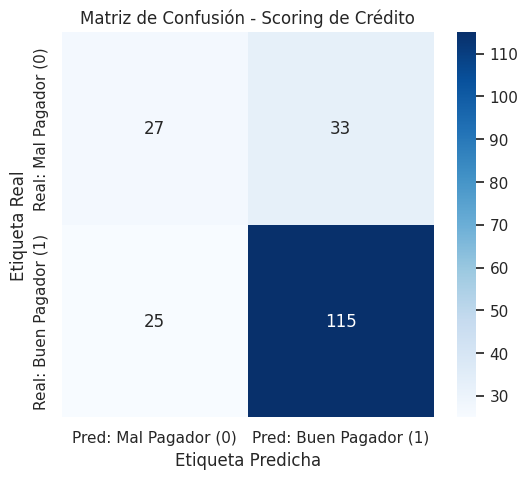

In [24]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Mal Pagador (0)', 'Pred: Buen Pagador (1)'],
            yticklabels=['Real: Mal Pagador (0)', 'Real: Buen Pagador (1)'])
plt.title('Matriz de Confusión - Scoring de Crédito')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

### 🏦 Interpretando la Matriz de Confusión desde la Banca

La matriz nos dice toda la verdad sobre los aciertos y errores del modelo:

En nuestro set de prueba de 200 personas (20% de 1000):
- 60 eran de Mal Pagador (`y_test.value_counts()`)
- 140 eran de Buen Pagador

Nuestros resultados:

- **Verdaderos Positivos (VP)**: `115`. El modelo predijo 'Buen Pagador' y el cliente *realmente* era Buen Pagador. **¡Acierto!** Le dimos un crédito a alguien que pagará.
- **Verdaderos Negativos (VN)**: `27`. El modelo predijo 'Mal Pagador' y el cliente *realmente* era Mal Pagador. **¡Acierto!** Evitamos una pérdida.
- **Falsos Positivos (FP)**: `33`. El modelo predijo 'Buen Pagador' (Positivo) pero el cliente *realmente* era Mal Pagador (Negativo). **¡Error Tipo I! ☠️** Este es el **costo directo** para el banco: aprobamos un crédito a alguien que no pagará.
- **Falsos Negativos (FN)**: `25`. El modelo predijo 'Mal Pagador' (Negativo) pero el cliente *realmente* era Buen Pagador (Positivo). **¡Error Tipo II! 💸** Este es el **costo de oportunidad**: rechazamos a un buen cliente, perdiendo negocio y posiblemente enviándolo a la competencia.

A partir de esta matriz, podemos calcular métricas mucho más útiles que la exactitud.

In [25]:
print("--- Reporte de Clasificación (Scoring de Crédito) ---")
print(classification_report(y_test, y_pred_test, target_names=['Mal Pagador (0)', 'Buen Pagador (1)']))

# Calculamos la Especificidad manualmente (no viene en el reporte)
# Especificidad = VN / (VN + FP)
vn = cm[0, 0]
fp = cm[0, 1]
specificity = vn / (vn + fp)

print(f"Exactitud General: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"Especificidad (Identificar Mal Pagador): {specificity:.3f}")

--- Reporte de Clasificación (Scoring de Crédito) ---
                  precision    recall  f1-score   support

 Mal Pagador (0)       0.52      0.45      0.48        60
Buen Pagador (1)       0.78      0.82      0.80       140

        accuracy                           0.71       200
       macro avg       0.65      0.64      0.64       200
    weighted avg       0.70      0.71      0.70       200

Exactitud General: 0.710
Especificidad (Identificar Mal Pagador): 0.450


**Discusión Económica Central:**

Para el banco, ¿qué error es peor?

1.  **Falso Positivo (FP): `33` casos.** Le dimos un crédito a un mal cliente. **Costo: Pérdida directa (impago).**
2.  **Falso Negativo (FN): `25` casos.** Rechazamos a un buen cliente. **Costo: Costo de oportunidad (intereses no ganados).**

Generalmente, en la banca, **el costo de un impago (FP) es mucho mayor que el costo de oportunidad (FN)**. Perder el capital prestado es peor que no ganar unos intereses.

Por lo tanto, el banco querrá un modelo que **minimice los Falsos Positivos**. La métrica que mide esto es la **Especificidad** (qué tan bien atrapamos a los malos, `VN / (VN + FP)`).

Nuestro modelo tiene una **Especificidad de 0.45** (solo atrapó al 45% de los malos clientes). ¡Esto es un riesgo alto para el banco! Necesitamos un modelo que sea mejor en esta métrica.

**Recomendación Práctica**

- Ignora el accuracy y el weighted avg. Son métricas optimistas que ocultan los problemas.
- Mira las métricas recall, precision y f1-score. Ten en cuenta que la decisión de qué métrica utilizar no es una decisión estadística, es una **decisión de negocio** que depende de los costos y la estrategia de la empresa.
- Si necesitas una sola métrica para resumir qué tan bueno es tu modelo, usa el macro avg f1-score. Es la más honesta.

## La Curva ROC y el Poder de Discriminación (AUC)

¿Qué pasaría si cambiamos nuestro umbral de decisión? Por defecto, `LogisticRegression` predice '1' si la probabilidad es > 0.5. ¿Pero si fuéramos más estrictos (ej. > 0.7) o más laxos (ej. > 0.3)?

Métricas como la Precisión y el Recall dependen de UN solo umbral de decisión (por defecto, 0.5). La **Curva ROC** (Receiver Operating Characteristic)  nos libera de esa limitación, ya que es una gráfica que visualiza el *trade-off* entre dos métricas clave a medida que movemos ese umbral de decisión.

La curva grafica:

- **Eje Y: Tasa de Verdaderos Positivos (Sensibilidad / Recall)**
  - `VP / (VP + FN)`
  - De todos los que realmente eran Positivos (ej. 'Buen Pagador'), ¿qué porcentaje logré "atrapar"?

**Queremos que este número sea ALTO.** Queremos estar en la parte superior del gráfico.

**Sensibilidad**

![Sensibilidad](https://drive.google.com/uc?id=1lzmLnEa_xndAKA1delytG5UyJ2L8DJf3)

- **Eje X: Tasa de Falsos Positivos (1 - Especificidad)**
  - `FP / (VN + FP)`
  - De todos los que realmente eran Negativos (ej. 'Mal Pagador'), ¿qué porcentaje clasificamos incorrectamente como Positivo (ej. 'Buen Pagador')? --> Ej: Qué tan a menudo nos equivocamos y clasificamos a un mal pagador como si fuera buen pagador.
  - **Queremos que este número sea BAJO.** Queremos estar en la parte izquierda del gráfico.

**1 - Especificidad**

![1 - Especificidad](https://drive.google.com/uc?id=1N9E0EJs7IurldTnUUSFr34ZkUoxrYMTF)

**Interpretación:**

- **Esquina Superior Izquierda (Punto [0, 1]):** Es el "clasificador perfecto" 🏆. Tiene una Tasa de Verdaderos Positivos del 100% (atrapa a todos los buenos) y una Tasa de Falsos Positivos del 0% (no se equivoca con ninguno de los malos).
- **Línea Diagonal de 45° (Azar):** 🎰 Representa un modelo inútil (como lanzar una moneda). Para "atrapar" al 50% de los buenos, se equivoca con el 50% de los malos. Un modelo nunca debe estar por debajo de esta línea.
- **Nuestra Curva:** Debe estar lo más "abombada" (convexa) posible hacia la esquina superior izquierda.

El Área Bajo la Curva (AUC) es: 0.762


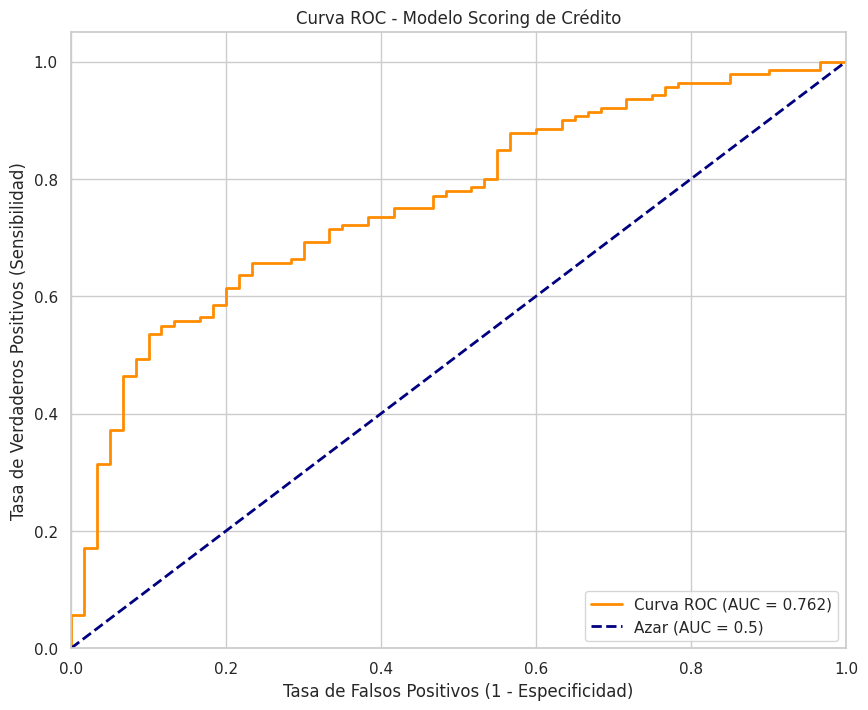

In [26]:
# 1. Obtenemos el 'false positive rate' (fpr) y 'true positive rate' (tpr) para varios umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

# 2. Calculamos el Área Bajo la Curva (AUC)
roc_auc = auc(fpr, tpr)

print(f"El Área Bajo la Curva (AUC) es: {roc_auc:.3f}")

# 3. Graficamos
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC - Modelo Scoring de Crédito')
plt.legend(loc="lower right")
plt.show()

#### ¿Qué es el AUC (Area Under the Curve - Área Bajo la Curva)?

El **AUC** es un número único que resume el poder de discriminación total del modelo, independientemente del umbral de decisión. Es un número entre 0 y 1.

**Reglas Prácticas de Interpretación:**

- **AUC = 1.0:** Clasificador Perfecto. Separa el 100% de las veces correctamente. (Si ves esto, probablemente tu modelo tenga overfitting o un error).
- **AUC > 0.9:** Sobresaliente (o sospechosamente bueno).
- **AUC > 0.8:** Excelente.
- **AUC > 0.7:** Bueno / Aceptable.
- **AUC > 0.6:** Pobre. El modelo tiene problemas para discriminar.
- **AUC = 0.5:** Inútil. Equivale al azar (la línea diagonal). El modelo no tiene ningún poder de discriminación, acierta tanto como se equivoca, sin ningún patrón. Si toma un cliente Bueno y uno Malo, tiene un 50% de probabilidad de adivinar cuál es cuál. Esto es un modelo "tonto".
- **AUC < 0.5:** El modelo predice al revés. El modelo no es "tonto" (como el de 0.5); es sistemáticamente incorrecto. Ha aprendido la lógica del negocio, pero exactamente al revés. Usualmente ocurre porque el y_train con el que el modelo aprendió y el y_test tienen definiciones opuestas de lo que significa 1 y 0.

**Nuestro AUC de 0.76** es "aceptable". Nos dice que el modelo tiene un poder de discriminación decente, pero que hay un claro espacio para mejorar. Un banco real exigiría un AUC > 0.85 para un modelo en producción.

**El AUC permite comparar modelos de forma robusta:** Si el Modelo A (Regresión Logística) tiene un AUC de 0.77 y el Modelo B (Random Forest) tiene un AUC de 0.82, podemos afirmar con confianza que el Modelo B es mejor para discriminar el riesgo crediticio, independientemente del umbral de aprobación que el banco decida usar al final.

## Interpretación de los Coeficientes del Modelo

Finalmente, una de las grandes ventajas de la regresión logística es que podemos interpretar sus coeficientes para entender qué variables influyen en la decisión.

Un coeficiente positivo significa que un aumento en esa variable aumenta la probabilidad de ser clasificado como **'Buen Pagador' (1)**. Un coeficiente negativo, la disminuye (aumenta la prob. de ser 'Mal Pagador').

Un coeficiente (coef) de regresión logística por sí solo es un logaritmo de odds.

**Odds:** a veces traducidos como "probabilidades relativas" o "razón de chances". Son una forma de expresar la probabilidad de que ocurra un evento frente a la probabilidad de que no ocurra.

$$ Odds = \frac{P(1)}{\left(1 - P(1)\right)}. $$

Imagina que lanzas un dado de 6 caras y quieres sacar un "3":

- **Probabilidad:** Tienes 1 caso favorable (sacar "3") y 6 casos totales. Tu probabilidad es 1/6 (o 16.6%).
-	**Odds:** Tienes 1 caso favorable (sacar "3") y 5 casos no favorables (sacar 1, 2, 4, 5 o 6). Tus "odds" son 1/5 (o 0.2), es decir, por cada 1 vez que esperas sacar el número 3, esperas no sacarlo 5 veces.

**La interpretación de los coeficientes es poco intuitiva:**
- Por cada año adicional de edad, el logaritmo de los odds de ser 'Buen Pagador' aumenta en 0.22.

In [27]:
# Creamos un DataFrame para ver los coeficientes
coeficientes = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': log_reg.coef_[0]
})
# Ordenamos por el valor del coeficiente para ver los más influyentes
coeficientes_sorted = coeficientes.sort_values(by='Coeficiente', ascending=False)
coeficientes_sorted

,Variable,Coeficiente
14,Propósito_Automóvil (usado),1.84
34,Otros deudores/fiadores_Garante,1.29
9,Estado de la cuenta corriente existente_Sin cu...,1.28
20,Propósito_Radio / Televisión,0.86
10,Historia de crédito_Cuenta crítica / Otros cré...,0.75
39,Otros planes de pago_Ninguno,0.72
17,Propósito_Muebles / Equipo,0.71
18,Propósito_Negocios,0.63
41,Alojamiento_Gratuita,0.59
28,Empleo actual desde_Entre 4 y 7 años,0.55


**Odds Ratio** (`np.exp(coef)`) se utiliza para una interpretación más intuitiva. Consiste en calcular el exponencial del coeficiente para deshacer el logaritmo natural.

**Interpretación**

- Manteniendo todas las demás variables constantes, por cada año adicional de edad que tiene un cliente, los 'odds' de que sea un 'Buen Pagador' se multiplican por 1.25.

También podemos convertir el odds ratio a porcentaje, en este caso:

1.25 - 1 = 0.25 * 100 = 25%

- Manteniendo todo lo demás constante, cada año adicional de edad aumenta los 'odds' de ser un 'Buen Pagador' en un 25%.

In [28]:
# Calculamos el Odds Ratio (más fácil de interpretar)
coeficientes_sorted['Odds_Ratio'] = np.exp(coeficientes['Coeficiente'])

print("Variables que más aumentan la probabilidad de 'Buen Pagador':")
display(coeficientes_sorted.head(10))

Variables que más aumentan la probabilidad de 'Buen Pagador':


,Variable,Coeficiente,Odds_Ratio
14,Propósito_Automóvil (usado),1.84,6.27
34,Otros deudores/fiadores_Garante,1.29,3.64
9,Estado de la cuenta corriente existente_Sin cu...,1.28,3.60
20,Propósito_Radio / Televisión,0.86,2.37
10,Historia de crédito_Cuenta crítica / Otros cré...,0.75,2.12
39,Otros planes de pago_Ninguno,0.72,2.05
17,Propósito_Muebles / Equipo,0.71,2.04
18,Propósito_Negocios,0.63,1.88
41,Alojamiento_Gratuita,0.59,1.81
28,Empleo actual desde_Entre 4 y 7 años,0.55,1.74


**Interpretación**

- Manteniendo todo lo demás constante, los 'odds' de que un cliente sea un 'Buen Pagador' se multiplican por 6.27 si el propósito del crédito es comprar un automóvil usado, en comparación con un cliente de la categoría de referencia.

También podemos convertir el odds ratio a porcentaje, en este caso:

6.27 - 1 = 5.27 * 100 = 527%

- Solicitar un crédito para un automóvil usado aumenta los 'odds' de ser un 'Buen Pagador' en un 527% , en comparación con la categoría de referencia.

In [29]:
print("\nVariables que más aumentan la probabilidad de 'Mal Pagador':")
display(coeficientes_sorted.tail(10))


Variables que más aumentan la probabilidad de 'Mal Pagador':


,Variable,Coeficiente,Odds_Ratio
1,Monto del crédito,-0.34,0.71
23,Cuenta de ahorros/bonos_Entre 100 y 500 DM,-0.36,0.70
12,Historia de crédito_Sin créditos / Todos pagados,-0.39,0.68
7,Estado de la cuenta corriente existente_Menos ...,-0.40,0.67
13,Historia de crédito_Todos los créditos en este...,-0.42,0.66
31,Estado personal y sexo_Hombre: divorciado/sepa...,-0.44,0.65
24,Cuenta de ahorros/bonos_Entre 500 y 1000 DM,-0.48,0.62
37,Propiedad_Desconocido / Sin propiedad,-0.70,0.50
25,Cuenta de ahorros/bonos_Menos de 100 DM,-0.85,0.43
47,Trabajador extranjero_Sí,-1.00,0.37


**Interpretación**

- Manteniendo todas las demás variables constantes, el hecho de ser un 'Trabajador Extranjero' multiplica los 'odds' de ser un 'Buen Pagador' por 0.37.

Esto es un poco confuso, por lo que es mejor usar la interpretación porcentual:

0.37 - 1 = -0.63 * 100 = -63%

- Manteniendo todo lo demás constante, ser un 'Trabajador Extranjero' disminuye los 'odds' de ser considerado un 'Buen Pagador' en un 63%, en comparación con un trabajador local (la categoría de referencia).